In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "ranked_quadh"

In [5]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])
data = ObjIter([ Tree(module.JetHT_Data_UL_List) ])

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
def n_presel_jet(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jet)

[None, None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/"


In [10]:
(signal+bkg+data).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 6/6 [00:28<00:00,  4.77s/it]


[None, None, None, None, None, None]

In [17]:
(signal+bkg+data).apply(lambda t : eightb.pair_y_from_higgs(t, operator=eightb.y_min_mass_asym), report=True)

100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


[None, None, None, None, None, None]

In [12]:
select_jetpt = eightb.selected_jet_ptregressed()

signal = signal.apply(select_jetpt)
bkg = bkg.apply(select_jetpt)
data = data.apply(select_jetpt)

In [13]:
select_jetbtagwp = eightb.selected_jet_btagwp()

signal = signal.apply(select_jetbtagwp)
bkg = bkg.apply(select_jetbtagwp)
data = data.apply(select_jetbtagwp)

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


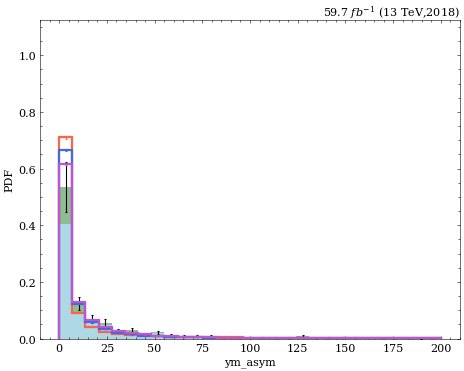

In [49]:
def ym_asym(t):
    ym_asym=np.abs(t.Y1_m - t.Y2_m)**2/(t.Y1_m + t.Y2_m)
    t.extend(ym_asym=ym_asym)
    return ym_asym
(signal+bkg+data).apply(ym_asym)
study.quick( 
    signal+bkg,
    varlist=['ym_asym'],
    binlist=[(0,200,30)],
    efficiency=True,
)

In [54]:
bdt_classifier = BDTClassifier(
    ['higgs_m[:,0]','higgs_m[:,1]','higgs_m[:,2]','higgs_m[:,3]', 'ym_asym']
    # ['higgs_m[:,0]','higgs_m[:,1]','higgs_m[:,2]','higgs_m[:,3]']
    )

In [55]:
bdt_classifier.train(bkg, signal)
bdt_classifier.print_results(bkg, signal)

--- BDT Classifier Results ---
AUROC = 0.715


In [50]:
(signal+bkg+data).apply(lambda t : t.extend(bdt_score=bdt_classifier.predict_tree(t)))

[None, None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


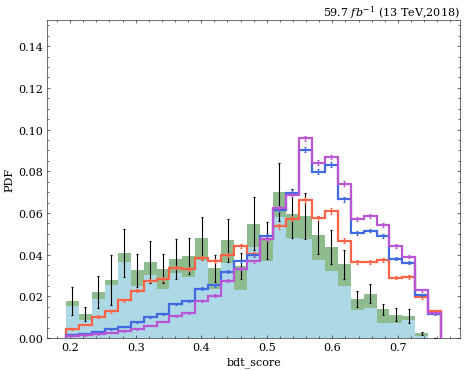

In [51]:
study.quick( 
    signal+bkg,
    varlist=['bdt_score'],
    efficiency=True,
)

In [56]:
def build_bdt_features(t):
    jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)

    j1_phi, j2_phi = ak.unzip(ak.combinations(t.jet_phi, n=2, axis=-1))
    jet_dphi = calc_dphi(j1_phi, j2_phi)

    j1_eta, j2_eta = ak.unzip(ak.combinations(t.jet_eta, n=2, axis=-1))
    jet_deta = calc_deta(j1_eta, j2_eta)

    min_jet_deta = ak.min( np.abs(jet_deta), axis=-1)
    max_jet_deta = ak.max( np.abs(jet_deta), axis=-1)

    jet_dr = np.sqrt( jet_deta**2 + jet_dphi**2 )

    min_jet_dr = ak.min(jet_dr, axis=-1)
    max_jet_dr = ak.max(jet_dr, axis=-1)

    h1_phi, h2_phi = ak.unzip(ak.combinations(t.higgs_phi, n=2, axis=-1))
    higgs_dphi = calc_dphi(h1_phi, h2_phi)

    h1_eta, h2_eta = ak.unzip(ak.combinations(t.higgs_eta, n=2, axis=-1))
    higgs_deta = calc_deta(h1_eta, h2_eta)

    comb_id = ak.combinations(np.arange(4), n=2, axis=0)
    t.extend(
        jet_ht=jet_ht,
        min_jet_deta=min_jet_deta,
        max_jet_deta=max_jet_deta,
        min_jet_dr=min_jet_dr,
        max_jet_dr=max_jet_dr,
        h_h_dphi=np.abs(higgs_dphi),
        h_h_deta=np.abs(higgs_deta)
    )
(signal+bkg+data).apply(build_bdt_features, report=True)

100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


[None, None, None, None, None, None]

In [57]:
varinfo.higgs_pt = dict(bins=(0,500,30))
varinfo.higgs_m = dict(bins=(0,300,30))

100%|██████████| 29/29 [00:06<00:00,  4.81it/s]


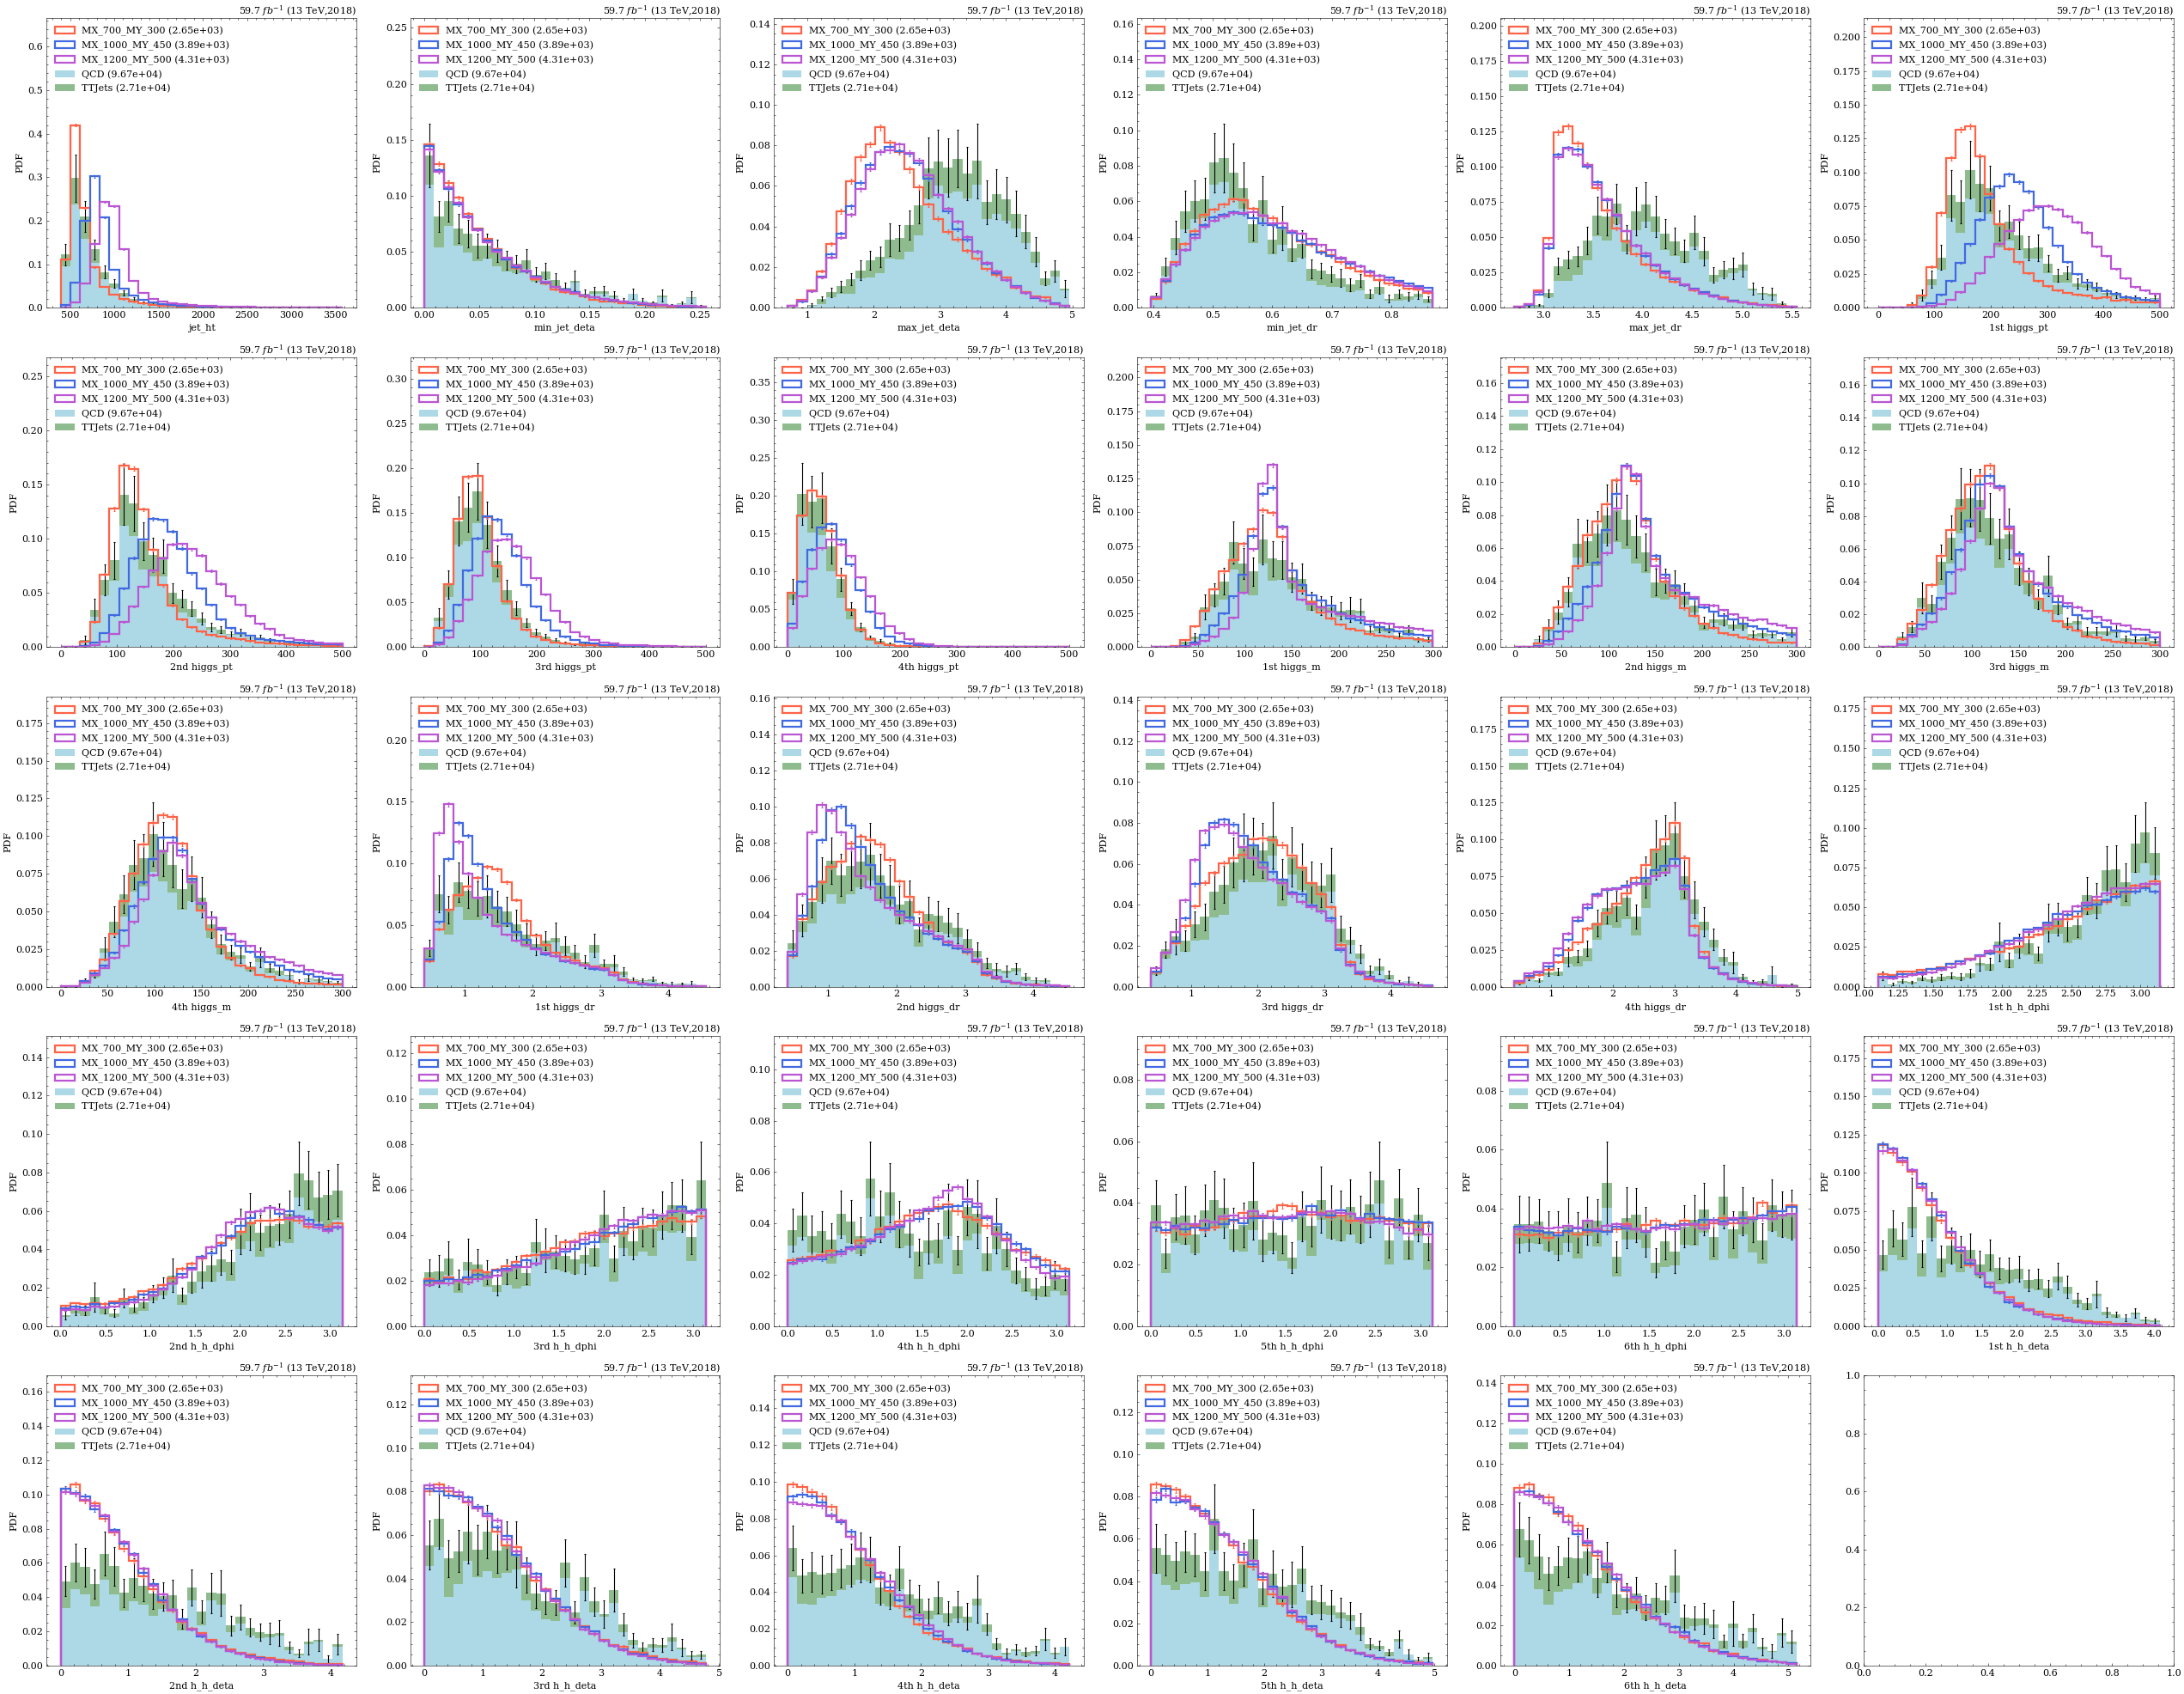

In [59]:
study.quick( 
    signal+bkg,
    legend=True,
    varlist=[
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'higgs_{var}[:,{i}]'
        for var in ('pt','m','dr')
        for i in range(4)
    ] + [
        f'h_h_{var}[:,{i}]'
        for var in ('dphi','deta')
        for i in range(6)
    ],
    efficiency=True

)

In [18]:
features = [
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'higgs_{var}[:,{i}]'
        for i in range(4)
        for var in ('pt','m','dr')
    ] + [
        f'h_h_{var}[:,{i}]'
        for i in range(6)
        for var in ('dphi','deta')
    ]

In [19]:
ar_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm < ar_region[2]),
    b = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm < ar_region[2]),
    c = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm > ar_region[2]) & (t.higgs_dm < ar_region[3]),
    d = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm > ar_region[2]) & (t.higgs_dm < ar_region[3]),
)

In [20]:
vr_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm < vr_region[2]),
    b = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm < vr_region[2]),
    c = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm > vr_region[2]) & (t.val_higgs_dm < vr_region[3]),
    d = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm > vr_region[2]) & (t.val_higgs_dm < vr_region[3]),
)

In [21]:
blind_filter = EventFilter('blinded', filter=lambda t : ~( ar_bdt.a(t) ))
blinded_data  = data.apply(blind_filter)

In [22]:
bkg_model = blinded_data .asmodel('bkg model')

In [34]:
[ ak.sum(bkg_model.apply(getattr(ar_bdt, region)).awk,axis=1) for region in ('a','b','c','d') ]

[<Array [0] type='1 * int64'>,
 <Array [25715] type='1 * int64'>,
 <Array [4378] type='1 * int64'>,
 <Array [14149] type='1 * int64'>]

In [32]:
[ ak.sum(bkg_model.apply(getattr(vr_bdt, region)).awk,axis=1) for region in ('a','b','c','d') ]

[<Array [1362] type='1 * int64'>,
 <Array [4541] type='1 * int64'>,
 <Array [1516] type='1 * int64'>,
 <Array [4980] type='1 * int64'>]

In [23]:
vr_bdt.train(bkg_model)
vr_bdt.print_results(bkg_model)

--- ABCD Results ---
k = 3.044e-01
k*(b/a)-1  = 1.49%
BDT(b)/a-1 = 1.49%



100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


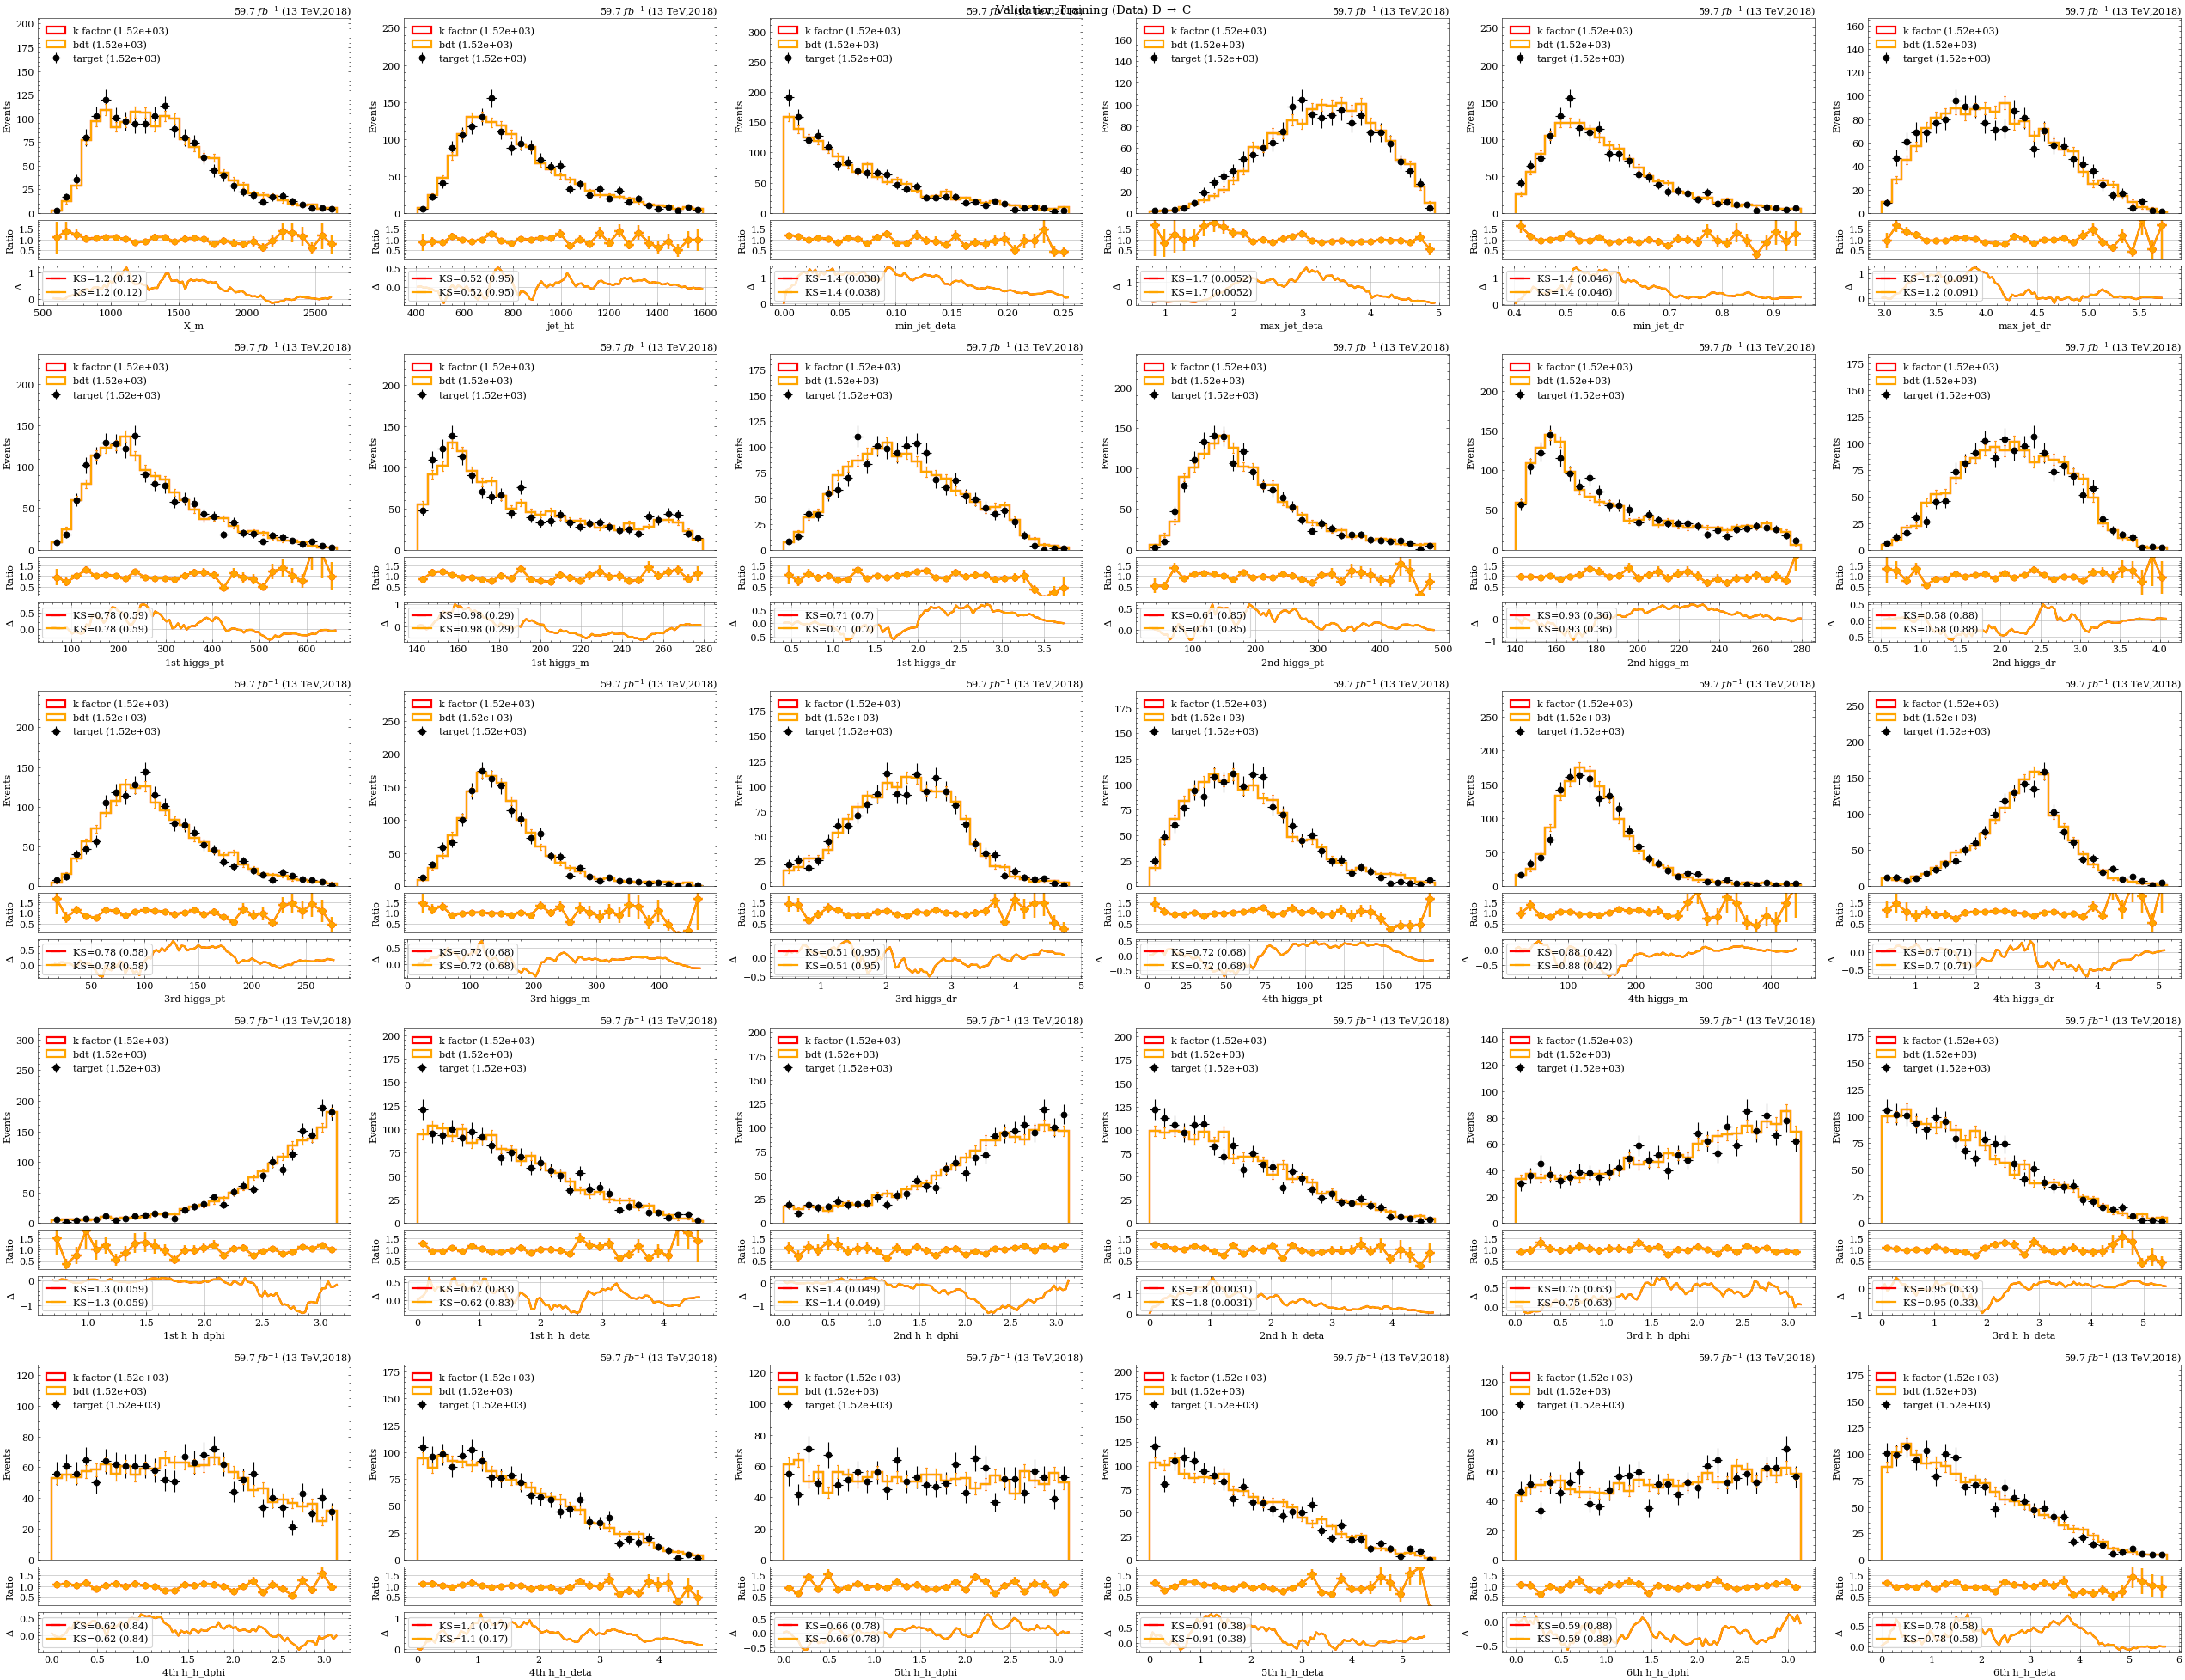

In [24]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[vr_bdt.c]*len(data)+[vr_bdt.d]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m']+vr_bdt.feature_names,
    suptitle='Validation Training (Data) D $\\rightarrow$ C',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/training'
)

100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


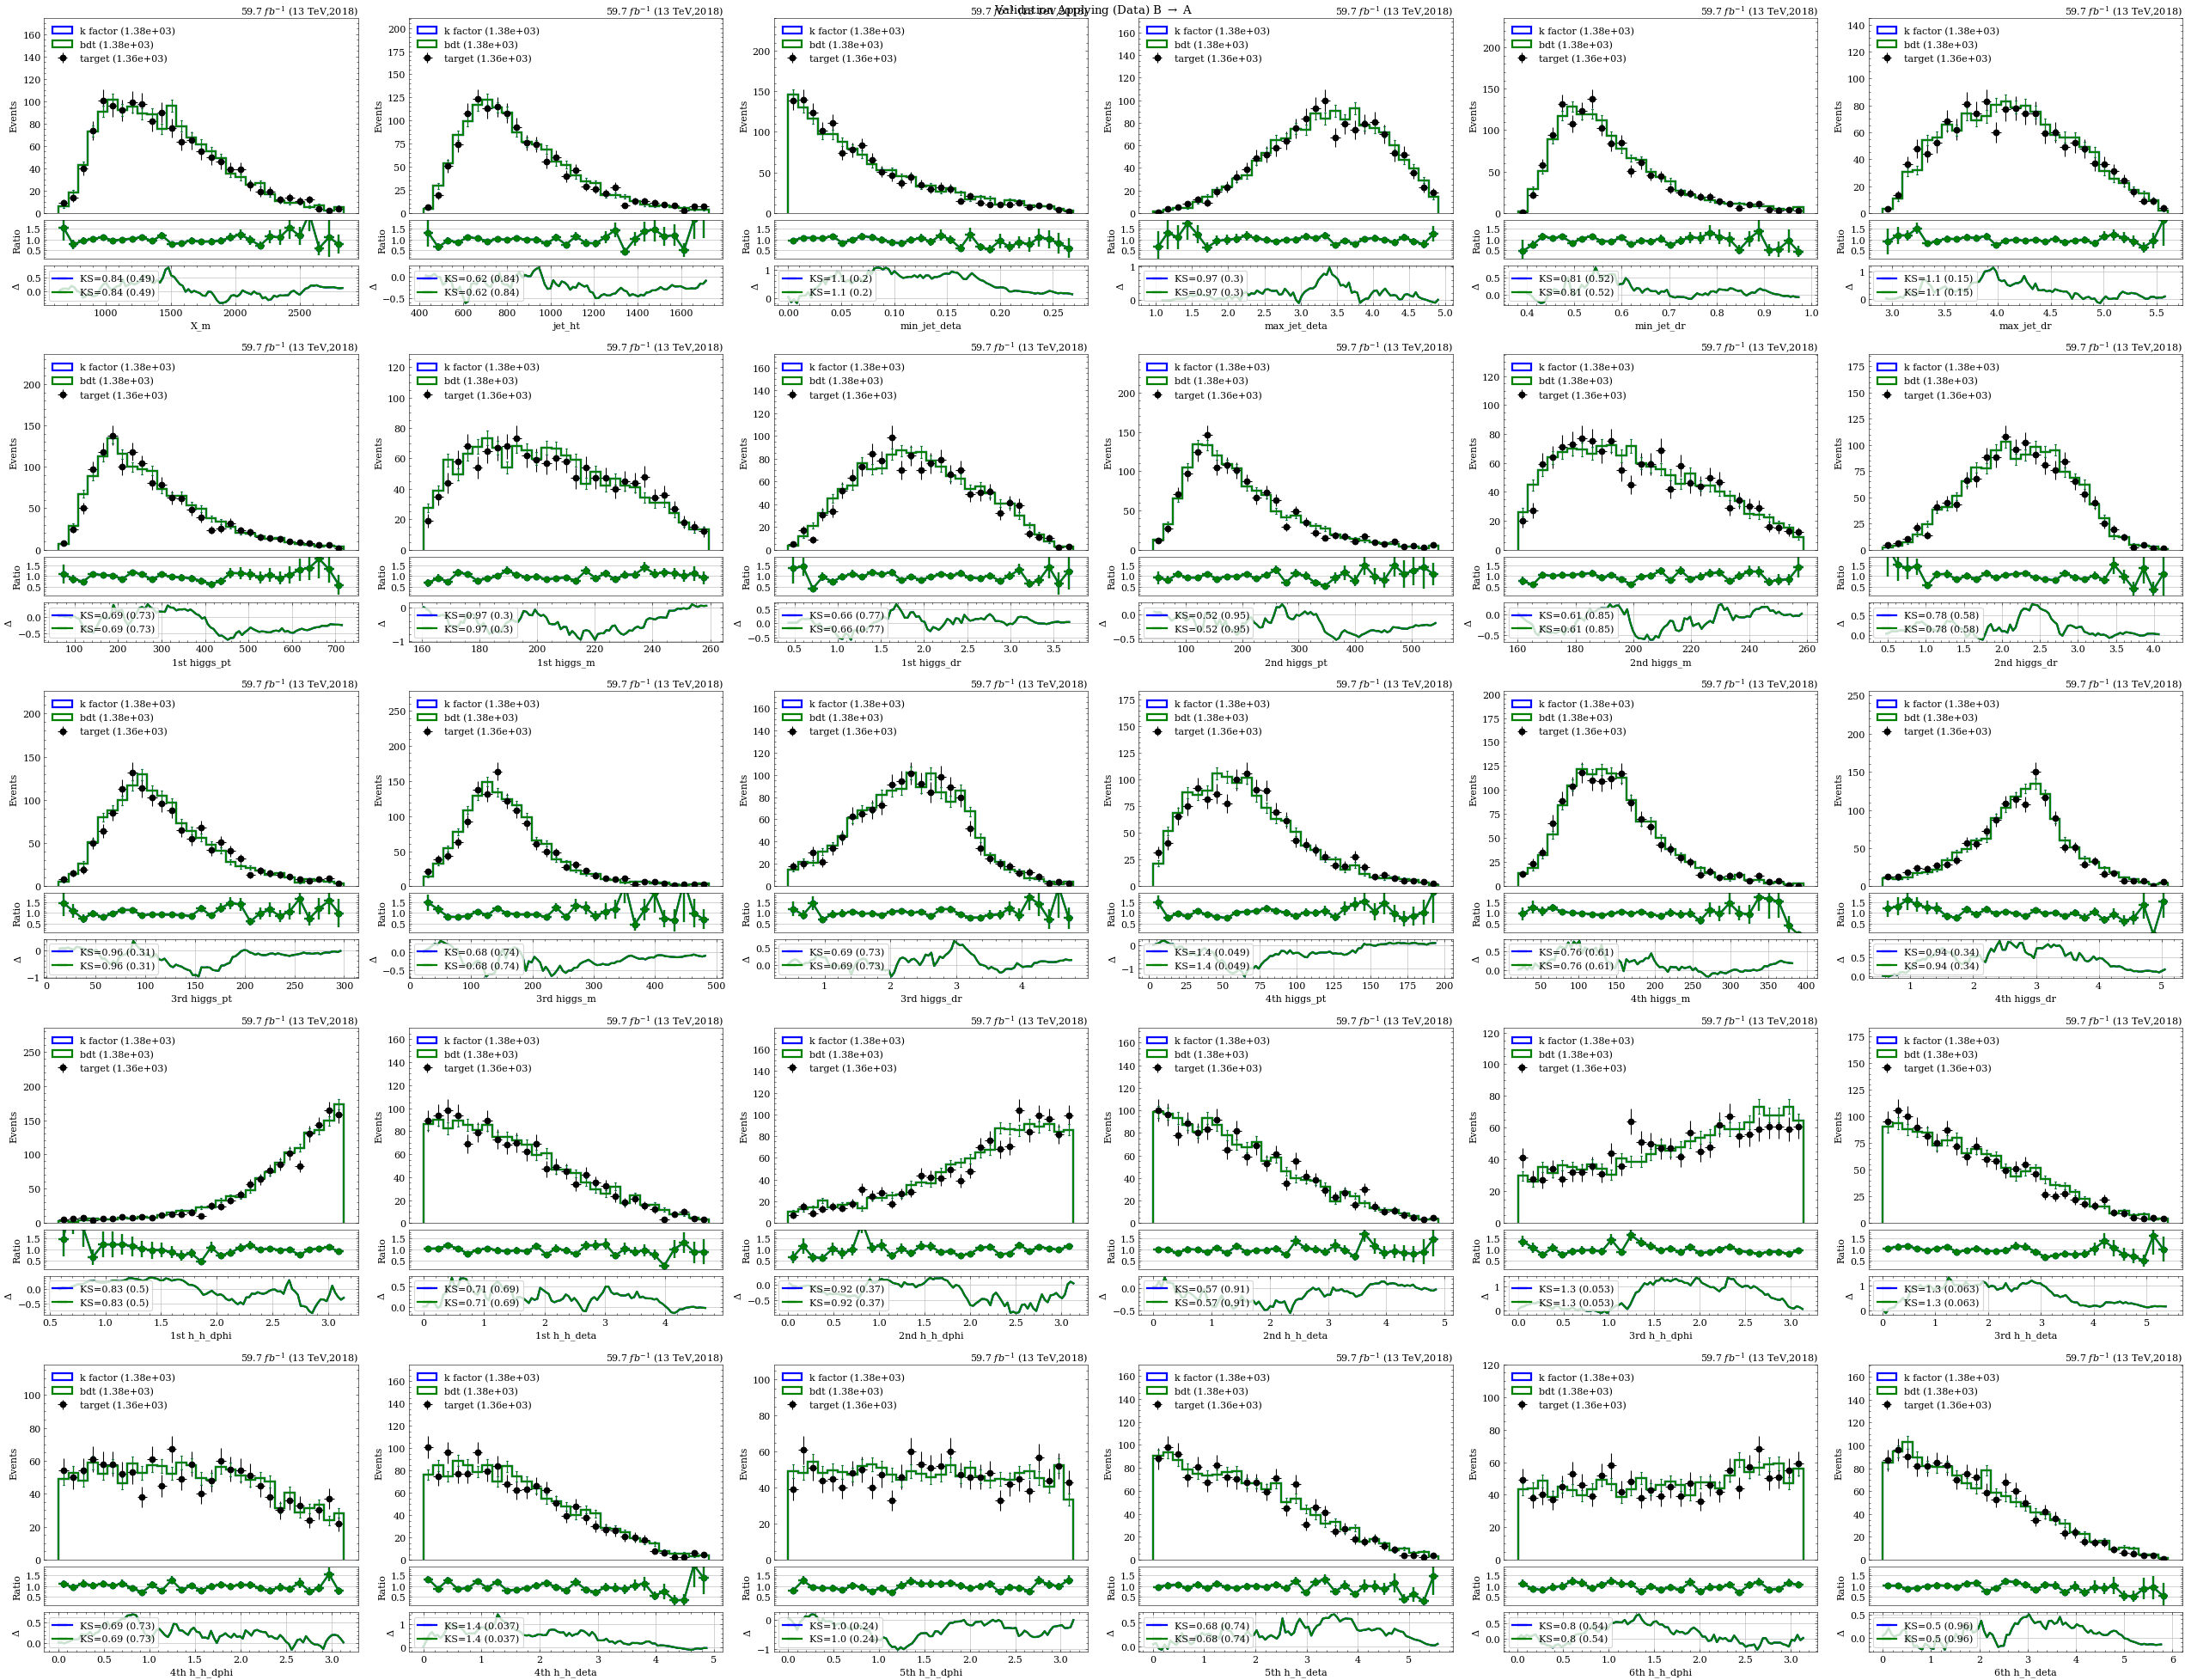

In [25]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[vr_bdt.a]*len(data)+[vr_bdt.b]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m']+vr_bdt.feature_names,
    suptitle='Validation Applying (Data) B $\\rightarrow$ A',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/applying',
)

In [26]:
ar_bdt.train(bkg_model)
ar_bdt.print_results(bkg_model)

--- ABCD Results ---
k = 3.094e-01
k*(b/a)-1  = inf%
BDT(b)/a-1 = inf%



100%|██████████| 1/1 [00:16<00:00, 16.78s/it]


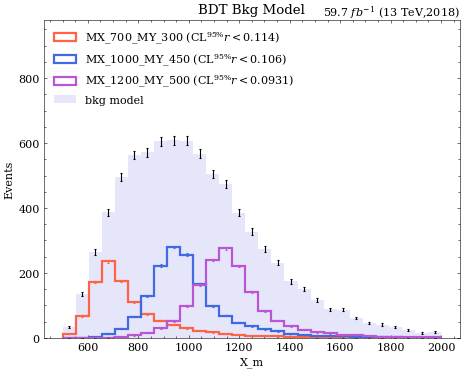

In [27]:
study.quick(
    signal + bkg_model, 
    legend=True,
    masks=[ar_bdt.a]*len(signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    binlist=[(500,2000,30)],
    title='BDT Bkg Model',
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)

100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


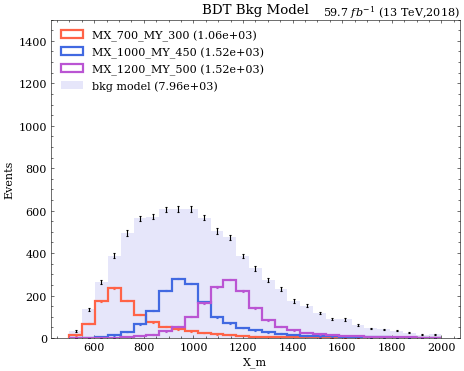

In [30]:
study.quick(
    signal + bkg_model, 
    legend=True,
    masks=[ar_bdt.a]*len(signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    ylim=(0,1500),
    binlist=[(500,2000,30)],
    title='BDT Bkg Model',
)

In [29]:
1.52e3/np.sqrt(7.96e3)

17.036761907164372